In [5]:
import os  
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns  
import re


from nltk.corpus import stopwords  
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score  
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')

data = pd.read_csv('UpdatedResumeDataSet.csv' ,encoding='utf-8')
data.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [7]:
#카테고리별 이력서 데이터 분포
data['Category'].value_counts().reset_index()

,Category,count
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


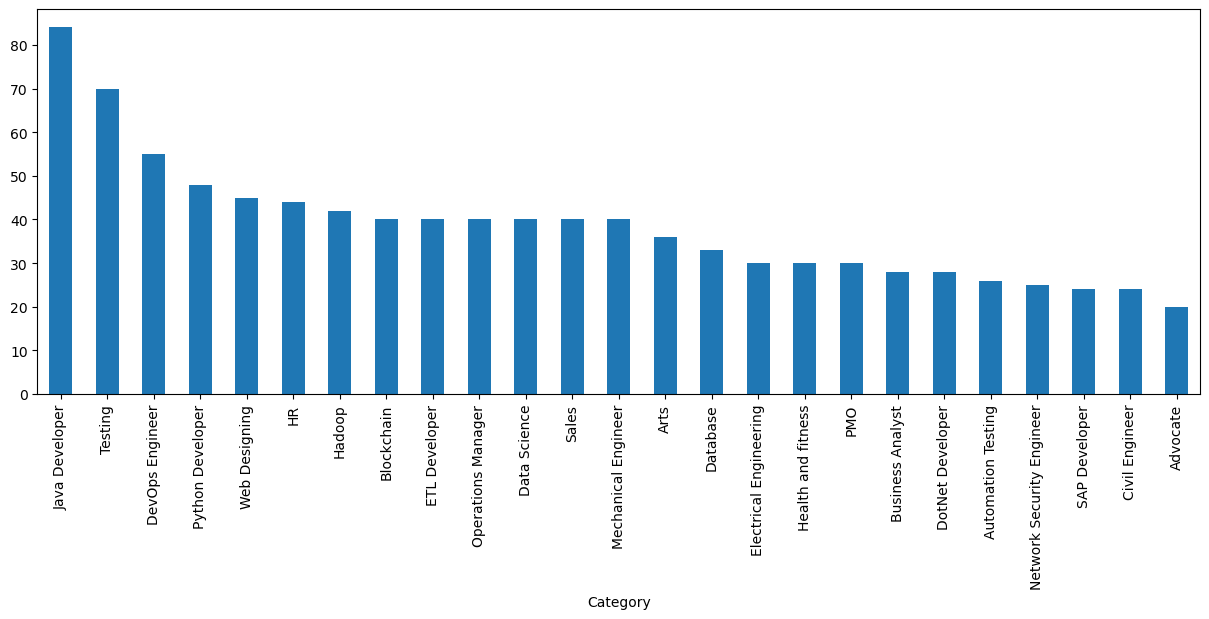

In [9]:
plt.figure(figsize=(15,5))
data["Category"].value_counts().plot(kind="bar")
plt.show()

In [10]:
data.duplicated(keep='first').value_counts()

True     796
False    166
Name: count, dtype: int64

In [5]:
data.duplicated(['Resume'], keep='first').value_counts()

True     796
False    166
dtype: int64

- 데이터 중복값 존재
- 962개 중 중복값 796개 


In [6]:
#중복 데이터 확인
data_dup = data[data.duplicated(['Resume'], keep='first')]
data_dup['Resume'].value_counts().reset_index()

,index,Resume
0,"Technical Skills Web Technologies: Angular JS,...",17
1,Skills VISA B1-VISA (USA) Onsite Visits to Swe...,16
2,Software Proficiency: â¢ Languages: Basics of...,16
3,CORE COMPETENCIES ~ Ant ~ Maven ~ GIT ~ Bitbuc...,16
4,"TECHNICALSKILLS SpringMVC, Hibernate, JDBC, Ja...",11
...,...,...
157,Skills Legal Writing Efficient researcher Lega...,1
158,Good grasping quality and skillful work Educat...,1
159,â¢ Hard working â¢ Quick learnerEducation De...,1
160,Education Details \r\n B.Tech Electronics And ...,1


In [7]:
#중복 데이터 제거
data_drop = data.drop_duplicates(subset="Resume", keep='first')
data_drop.head()
#data_drop.to_csv('data_drop.csv', index=False) #csv 파일 변환

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [8]:
data_drop.value_counts().reset_index()

,Category,Resume,0
0,Advocate,"Education Details \r\n B.Com, LL.B., Univers...",1
1,Health and fitness,Education Details \r\nJanuary 2018 M.S. Nutrit...,1
2,Health and fitness,Personal Skills: â¢ Good verbal and written c...,1
3,Health and fitness,SKILLS: Computer: â¢ Can easily operate in Op...,1
4,Java Developer,"Computer Skills: Languages And Script: JSP, Se...",1
...,...,...,...
161,Database,"TECHNICAL SKILL: Operating System LINUX, Windo...",1
162,Database,TECHNICAL SKILLS Operating Systems MS Windows ...,1
163,Database,"TECHNICAL SKILLS â¢ SQL â¢ Oracle v10, v11, ...",1
164,Database,Technical Expertise Operating Systems Microsof...,1


In [9]:
#중복제거 후, 카테고리 별 이력서 수
data_drop['Category'].value_counts().reset_index()

,index,Category
0,Java Developer,13
1,Database,11
2,Data Science,10
3,Advocate,10
4,HR,10
5,DotNet Developer,7
6,Hadoop,7
7,DevOps Engineer,7
8,Automation Testing,7
9,Testing,7


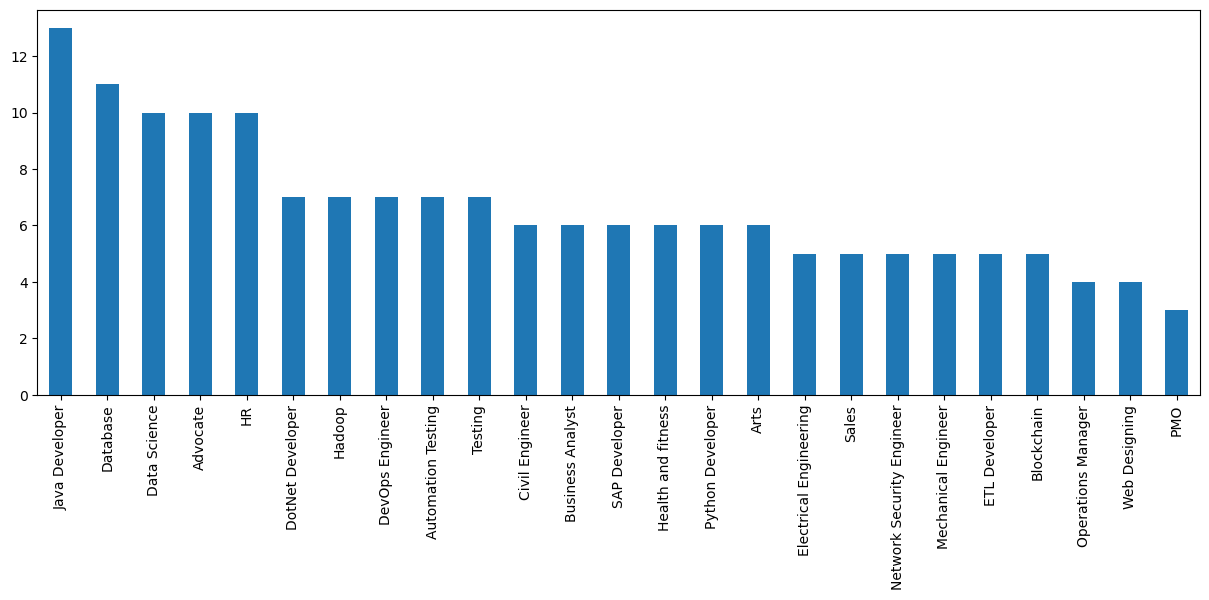

In [10]:
plt.figure(figsize=(15,5))
data_drop["Category"].value_counts().plot(kind="bar")
plt.show()

- 데이터의 과적합 가능성
- 불균형한 데이터의 문제
- 부족한 데이터의 문제

불용어 처리

In [11]:
def clean(text):

    # Compile patterns for URLs and emails to speed up cleaning process
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
    
    # Remove URLs
    clean_text = url_pattern.sub('', text)
    
    # Remove emails
    clean_text = email_pattern.sub('', clean_text)
    
    # Remove special characters (keeping only words and whitespace)
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    
    # Remove stop words by filtering the split words of the text
    stop_words = set(stopwords.words('english'))
    clean_text = ' '.join(word for word in clean_text.split() if word.lower() not in stop_words)
    
    return clean_text

In [12]:
data_drop["Resume"][0]

'Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details \r\n\r\nData Science Assurance Associate \r\n\r\nData Science Assurance Associate - Ernst & Young LLP\r\nSkill Details \r\nJAVASCRIPT- Exprience - 24 months\r\njQuery- Exprience - 24 months\r\nPython- Exprience - 24 monthsCompany Details \r\ncompany - Ernst & Young LLP\r\ndescription - Fraud Investigatio

In [13]:
data_drop["Resume"] = data_drop["Resume"].apply(lambda x: clean(x))

In [14]:
data_drop["Resume"][0]

'Skills Programming Languages Python pandas numpy scipy scikitlearn matplotlib Sql Java JavaScriptJQuery Machine learning Regression SVM NaÃve Bayes KNN Random Forest Decision Trees Boosting techniques Cluster Analysis Word Embedding Sentiment Analysis Natural Language processing Dimensionality reduction Topic Modelling LDA NMF PCA Neural Nets Database Visualizations Mysql SqlServer Cassandra Hbase ElasticSearch D3js DCjs Plotly kibana matplotlib ggplot Tableau Others Regular Expression HTML CSS Angular 6 Logstash Kafka Python Flask Git Docker computer vision Open CV understanding Deep learningEducation Details Data Science Assurance Associate Data Science Assurance Associate Ernst Young LLP Skill Details JAVASCRIPT Exprience 24 months jQuery Exprience 24 months Python Exprience 24 monthsCompany Details company Ernst Young LLP description Fraud Investigations Dispute Services Assurance TECHNOLOGY ASSISTED REVIEW TAR Technology Assisted Review assists accelerating review process run ana

Label Encoder

In [15]:
# Initialize the Label Encoder
le = LabelEncoder()

# Fit the label encoder on the 'Category' column to learn the unique categories
le.fit(data_drop["Category"])

# Transform the 'Category' column into encoded numerical values
data_drop["Category"] = le.transform(data_drop["Category"])

In [16]:
data_drop.Category.unique()

array([ 6, 12,  0,  1, 24, 16, 22, 14,  5, 15,  4, 21,  2, 11, 18, 20,  8,
       17, 19,  7, 13, 10,  9,  3, 23])

POS of Tagging of Token

In [17]:
data_drop

,Category,Resume
0,6,Skills Programming Languages Python pandas num...
1,6,Education Details May 2013 May 2017 UITRGPV Da...
2,6,Areas Interest Deep Learning Control System De...
3,6,Skills â R â Python â SAP HANA â Tableau â SAP...
4,6,Education Details MCA YMCAUST Faridabad Haryan...
...,...,...
894,23,Computer Skills â Proficient MS office Word Ba...
895,23,â Willingness accept challenges â Positive thi...
896,23,PERSONAL SKILLS â Quick learner â Eagerness le...
897,23,COMPUTER SKILLS SOFTWARE KNOWLEDGE MSPower Poi...


In [18]:
corpus = " "
for i in range(len(data_drop)):
    corpus += data_drop.iloc[i]["Resume"]

In [19]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tkrhk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
lemmatizer = WordNetLemmatizer()

# NLTK POS 태그를 WordNet 품사 태그로 변환
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatization을 적용하는 함수
def lemmatize_text(text):
    # 토큰화 및 POS 태깅
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    
    # Lemmatization
    lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    return ' '.join(lemmas)

# 'cleaned' 열에 lemmatization 적용
data_drop['Resume'] = data_drop['Resume'].apply(lemmatize_text)


TF-IDF 벡터화
- TF-IDF: 텍스트 데이터를 숫자 형태로 변환하는 과정에서 중요한 단어들의 가중치를 부여하는 방식

In [22]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Fit the TF-IDF vectorizer on the 'Resume' column to learn the vocabulary and IDF of the words
tfidf.fit(data_drop["Resume"])

# Transform the 'Resume' texts into a sparse matrix of TF-IDF features
resume = tfidf.transform(data_drop["Resume"])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(resume, data_drop["Category"], test_size=0.2, random_state=42)

In [24]:
data_drop["Category"].unique()

array([ 6, 12,  0,  1, 24, 16, 22, 14,  5, 15,  4, 21,  2, 11, 18, 20,  8,
       17, 19,  7, 13, 10,  9,  3, 23])

In [25]:
X_train.shape, y_train.shape

((132, 7528), (132,))

모델 성능 비교

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Define a dictionary to hold models
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(),
    'MultinomialNB': MultinomialNB()
}

# Dictionary to hold accuracy scores
accuracy_scores = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[model_name] = accuracy
    
    # Print the accuracy
    print(f'Accuracy of {model_name} on test set: {accuracy:.2f}')

Accuracy of KNeighborsClassifier on test set: 0.71
Accuracy of LogisticRegression on test set: 0.32
Accuracy of RandomForestClassifier on test set: 0.47
Accuracy of SVC on test set: 0.21
Accuracy of MultinomialNB on test set: 0.21
